<a href="https://colab.research.google.com/github/MaheeGamage/Product-Personalization/blob/dev/Product_personalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Config

In [147]:
# Google drive connection
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Basic config

In [148]:
capture_image_from_webcam = False
gdrive_products_path = "/Other/Dula MBA Experiment/Products"
get_config_from_gdrive_file = True

In [149]:
import json

manualJsonConfig = """
[
    {
        "imageName": "General_wallclock.png",
        "personImage": {
            "offset": {
                "x_offset": 217,
                "y_offset": 169
            },
            "center": {
                "x": 199,
                "y": 208
            },
            "size": {
                "max_width": 54,
                "max_height": 46
            }
        }
    },
    {
        "imageName": "Generic_milkpowder.png",
        "personImage": {
            "center": {
                "x": 199,
                "y": 350
            },
            "size": {
                "max_width": 99,
                "max_height": 110
            }
        }
    }
]
"""

Other Config. No need to change for execution

In [150]:
person_image_folder_path = '/content/PersonImage'
person_image_mask_folder_path = '/content/PersonImageMask'

background_remover_input_folder_path = '/content/MODNet/demo/image_matting/colab/input'
background_remover_output_folder_path = '/content/MODNet/demo/image_matting/colab/output'

products_image_path = "/content/drive/MyDrive" + gdrive_products_path
products_image_config_file_name = "image_generation_config.json"

personalized_image_output_path = '/content/PersonalizedImageOutput'

face_detection_classifier_path = products_image_path + "/src/haarcascade_frontalface_default.xml"

## Setup

In [151]:
# Folder Structure Setup
import os.path
from os import path
import shutil

rebuild_folder_paths = [person_image_folder_path, person_image_mask_folder_path, personalized_image_output_path]

# clean and rebuild the folders
for folder_path in rebuild_folder_paths:
  if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
  os.makedirs(folder_path)

In [152]:
for folder_path in rebuild_folder_paths:
  if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
  os.makedirs(folder_path)

In [153]:
# Background remover setup

import os
import shutil
from google.colab import files

# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/MaheeGamage/MODNet
%cd MODNet/

# dowload the pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1uXRxXvizrwSj9-FlxqEuwDIhkb9E28y5 \
          -O pretrained/modnet_photographic_portrait_matting.ckpt

# clean and rebuild the image folders
if os.path.exists(background_remover_input_folder_path):
  shutil.rmtree(background_remover_input_folder_path)
os.makedirs(background_remover_input_folder_path)

if os.path.exists(background_remover_output_folder_path):
  shutil.rmtree(background_remover_output_folder_path)
os.makedirs(background_remover_output_folder_path)

/content
/content/MODNet


In [154]:
import shutil
import os
from glob import glob

def getFilesPathInFolder(path):
  glob_pattern = os.path.join(path, '*')
  return glob(glob_pattern)

In [155]:
import cv2

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [156]:
import cv2

def resize_image_with_max_height_and_width(img, max_width=None, max_height=None):
    # Get the dimensions of the original image
    height, width = img.shape[:2]

    # Check if either max_width or max_height was provided
    if max_width is None and max_height is None:
        return img

    # Calculate the scaling factor needed to fit the image within the constraints
    width_scaling_factor = max_width / width if max_width else 1
    height_scaling_factor = max_height / height if max_height else 1
    scaling_factor = min(width_scaling_factor, height_scaling_factor)

    # Resize the image using the scaling factor
    new_width = int(width * scaling_factor)
    new_height = int(height * scaling_factor)
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    return resized_img


In [157]:
def calculateOffset(input_config, img):
  x_offset, y_offset = 0,0
  if 'offset' in input_config['personImage']:
    x_offset=input_config['personImage']['offset']['x_offset']
    y_offset=input_config['personImage']['offset']['y_offset']
  elif 'center' in input_config['personImage']:
    x_offset = int(input_config['personImage']['center']['x'] - (img.shape[0] / 2))
    y_offset = int(input_config['personImage']['center']['y'] - (img.shape[1] / 2))
  
  return (x_offset, y_offset)

In [158]:
# list files in given folder
def listFiles(path):
    fileList = []
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            fileList.append(file)
    return fileList

Face Detection Setup

In [159]:
# Don't need this to run this code since we have already store the given file in gDrive

# import urllib.request
# import os

# # Download the haarcascade_frontalface_default.xml file from OpenCV GitHub repository
# url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'
# if not os.path.exists(face_detection_classifier_path):
#     urllib.request.urlretrieve(url, face_detection_classifier_path)

## Capture Webcam image

In [160]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Fetch webcam photo or prompt for a image
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [161]:
from IPython.display import Image
from google.colab import files
import os


if capture_image_from_webcam :
  try:
    filename = take_photo(person_image_folder_path + "/photo.jpg")
    print('Saved to {}'.format(filename))
    # Show the image which was just taken.
    display(Image(filename))
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))
else :
  os.chdir(person_image_folder_path)
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving face.jpg to face.jpg
User uploaded file "face.jpg" with length 131084 bytes


In [162]:
# copy images from person image folder to background remover input folder
import shutil

# shutil.copytree(files(person_image_folder_path)[0], background_remover_input_folder_path, dirs_exist_ok=True) 
src = person_image_folder_path + "/" + listFiles(person_image_folder_path)[0]
dest = background_remover_input_folder_path
shutil.copy(src, dest) 

'/content/MODNet/demo/image_matting/colab/input/face.jpg'

## Remove background of person's image

In [163]:
%cd /content/MODNet

!python -m demo.image_matting.colab.inference \
        --input-path demo/image_matting/colab/input \
        --output-path demo/image_matting/colab/output \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt

/content/MODNet
Process image: face.jpg


Displaying Background Removed Image

In [164]:
import numpy as np
from PIL import Image

def combined_display(image, matte):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))
  
  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
  
  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  return combined, image, foreground, matte * 255

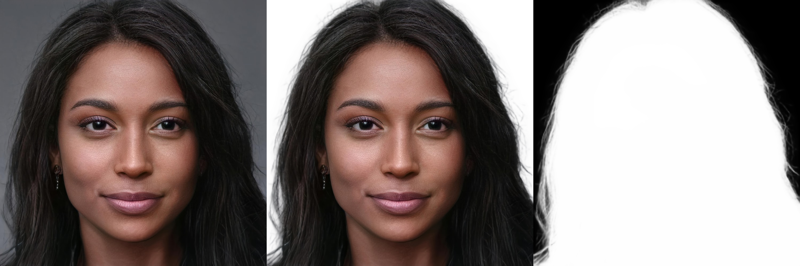

face.jpg 



In [165]:
# visualize all images
image_names = os.listdir(background_remover_input_folder_path)
for image_name in image_names:
  matte_name = image_name.split('.')[0] + '.png'
  image = Image.open(os.path.join(background_remover_input_folder_path, image_name))
  matte = Image.open(os.path.join(background_remover_output_folder_path, matte_name))
  display(combined_display(image, matte)[0])
  print(image_name, '\n')

In [166]:
# Copy background removed image to Person image folder

person_mask = getFilesPathInFolder(background_remover_output_folder_path)[0]
person_mask_file = os.listdir(background_remover_output_folder_path)[0].split('.')

shutil.copyfile(person_mask, person_image_mask_folder_path + "/" + person_mask_file[0] + "-mask." + person_mask_file[1])

'/content/PersonImageMask/face-mask.png'

## Fetching background images with configuration

In [167]:
# Scan Google drive location for product(background) images or prompt for product images

In [168]:
import json
from IPython.display import Image

%cd {products_image_path}

if get_config_from_gdrive_file:
  with open(products_image_config_file_name, "r") as fid: 
      productConfig = json.load(fid)
else :
  productConfig = json.loads(manualJsonConfig)

/content/drive/MyDrive/Other/Dula MBA Experiment/Products


[{'imageName': 'General_wallclock.png', 'personImage': {'offset': {'x_offset': 217, 'y_offset': 169}, 'size': {'max_width': 54, 'max_height': 46}}}, {'imageName': 'Generic_milkpowder.png', 'personImage': {'center': {'x': 199, 'y': 208}, 'size': {'max_width': 99, 'max_height': 110}}}]


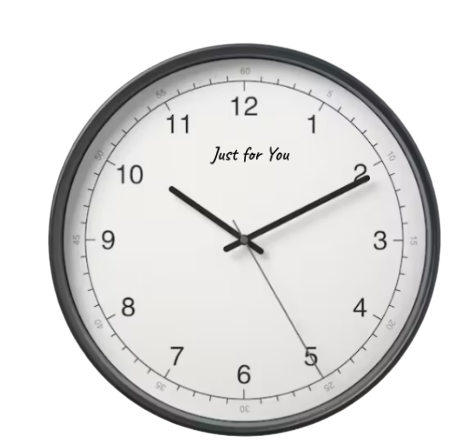

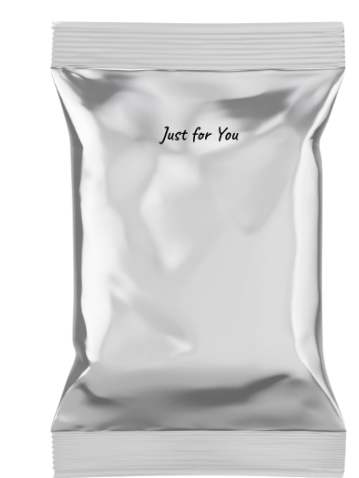

In [169]:
print(productConfig)

for product in productConfig:
    product_image = products_image_path + "/" + product["imageName"]
    display(Image(product_image))

## Pasting face image to background images with config

In [170]:
# Config person photo location for each product image

In [171]:
import cv2
from google.colab.patches import cv2_imshow

person_image_name = os.listdir(person_image_folder_path)[0]
person_image_file = person_image_folder_path + "/" + person_image_name

person_image_split = person_image_name.split('.')
mask_image_name = person_image_split[0] + '-mask.png'
mask_image_file = person_image_mask_folder_path + "/" + mask_image_name

## Detect face in the image

In [172]:
import urllib.request
import cv2
import numpy as np
import os

# Load the face detection classifier
face_cascade = cv2.CascadeClassifier(face_detection_classifier_path)

# Read image
img = cv2.imread(person_image_file)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the grayscale image
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
single_face_info = faces[0]

(x,y,w,h) = single_face_info

height = img.shape[0]
width = img.shape[1]
channels = img.shape[2]

relative_face_detection_info = (x/width, y/height, w/width, h/height)

## Loop through each product image and paste person image(background removed) into each product image

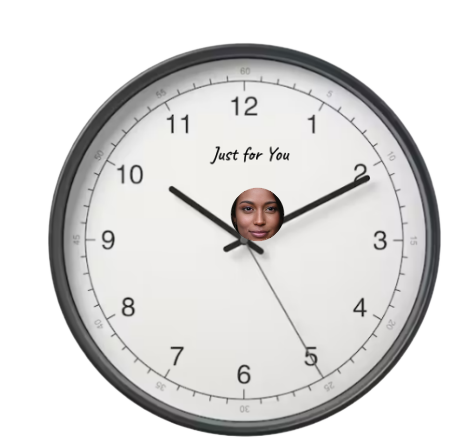

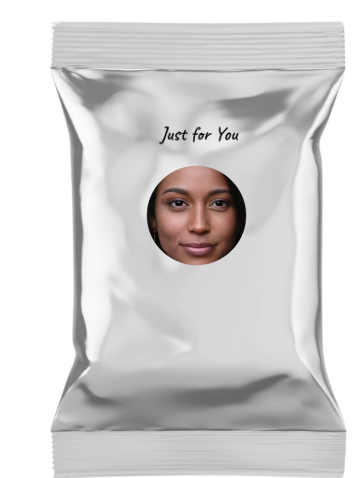

In [173]:
import copy

for product in productConfig:

  resized_max_width = int(product['personImage']['size']['max_width']/relative_face_detection_info[2])
  resized_max_height = int(product['personImage']['size']['max_width']/relative_face_detection_info[3])

  s_img_org = cv2.imread(person_image_file)
  s_img = resize_image_with_max_height_and_width(
      s_img_org, 
      max_width=resized_max_width, 
      max_height=resized_max_height
  )

  (x,y,w,h) = relative_face_detection_info
  height = s_img.shape[0]
  width = s_img.shape[1]

  detected_face = {
    'x': int(x*width),
    'y': int(y*height),
    'w': int(w*width),
    'h': int(h*height)
  }

  center = (detected_face['x'] + detected_face['w']//2, detected_face['y'] + detected_face['h']//2)
  radius = int(1 * detected_face['w']/2)
  face_mask = np.zeros_like(s_img)
  cv2.circle(face_mask, center, radius, (255, 255, 255), -1, cv2.LINE_AA)
  invered_face_mask = 1.0 - face_mask

  l_img = cv2.imread(products_image_path + "/" + product["imageName"], cv2.IMREAD_UNCHANGED)
  mask_org = cv2.imread(mask_image_file)
  mask = resize_image_with_max_height_and_width(
      mask_org, 
      max_width=resized_max_width, 
      max_height=resized_max_height
  )
  # Make circular face
  mask = cv2.bitwise_and(mask, face_mask)

  new_img = copy.copy(l_img)

  x_offset, y_offset = calculateOffset(product, s_img)

  y1, y2 = y_offset, y_offset + s_img.shape[0]
  x1, x2 = x_offset, x_offset + s_img.shape[1]

  alpha_s = mask[:,:,0] / 255.0
  alpha_l = 1.0 - alpha_s
  alpha_background_origina = l_img[:,:,3]

  for c in range(0, 3):
    new_img[y1:y2, x1:x2, c] = (alpha_s * s_img[:, :, c] + alpha_l * l_img[y1:y2, x1:x2, c])
  
  np.dstack([new_img, alpha_background_origina])

  cv2_imshow(new_img)
  cv2.imwrite(os.path.join(personalized_image_output_path, product['imageName']), new_img)

In [174]:
s_img.shape

(156, 156, 3)

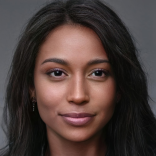

In [175]:
cv2_imshow(s_img)

In [176]:
mask.shape, face_mask.shape

((156, 156, 3), (156, 156, 3))

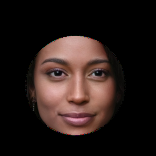

In [177]:
masked_img = cv2.bitwise_and(s_img, face_mask)
(y1, y2) = (center[1] - radius, center[1] + radius)
(x1, x2) = (center[0] - radius, center[0] + radius)
cropped_img = masked_img[y1:y2, x1:x2]
cv2_imshow(masked_img)

## Download Personalized images

In [178]:
%cd /content
zip_filename = listFiles(person_image_folder_path)[0].split(".")[0] + '.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)

os.system(f"zip -r -j {zip_filename} {personalized_image_output_path}/*")
files.download(zip_filename)

/content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

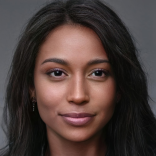

In [179]:
cv2_imshow(s_img)

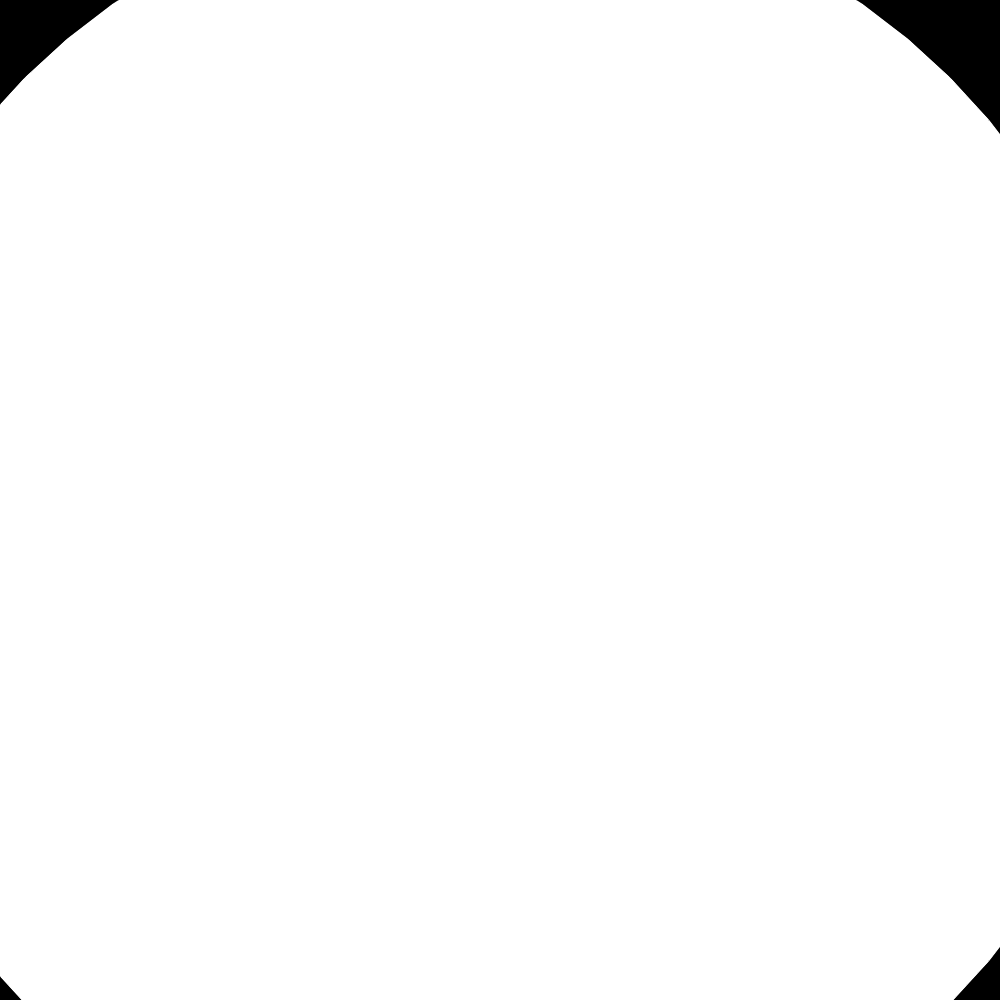

In [180]:
import urllib.request
import cv2
import numpy as np
import os
# Load the face detection classifier
face_cascade = cv2.CascadeClassifier(face_detection_classifier_path)

# Read image
img = cv2.imread(person_image_file)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the grayscale image
faces = face_cascade.detectMultiScale(gray, 1.1, 5)

# Crop the detected face in a circular form
for (x,y,w,h) in faces:
    center = (x + w//2, y + h//2)
    radius = int(2 * w/2)
    mask = np.zeros_like(img)
    cv2.circle(mask, center, radius, (255, 255, 255), -1, cv2.LINE_AA)
    masked_img = cv2.bitwise_and(img, mask)
    (y1, y2) = (center[1] - radius, center[1] + radius)
    (x1, x2) = (center[0] - radius, center[0] + radius)
    cropped_img = masked_img[y1:y2, x1:x2]

    # Display the cropped image
    cv2_imshow(mask)
